In [47]:
import numpy as np
from easydict import EasyDict
from collections import defaultdict
from sksurv.metrics import concordance_index_ipcw

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.models import CoxPH


In [48]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [49]:
from survtrace.dataset import load_data

# define the setup parameters
pc_hazard_config = EasyDict({
    'data': 'metabric',
    'horizons': [.25, .5, .75],
    'batch_size': 64,
    'learning_rate': 0.01,
    'epochs': 50,
    'hidden_size': 32
})
pc_hazard_config = EasyDict({
    'data': 'support',
    'horizons': [.25, .5, .75],
    'batch_size': 128,
    'learning_rate': 0.01,
    'epochs': 50,
    'hidden_size': 32
})


# load data
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(pc_hazard_config)


x_train = np.array(df_train, dtype='float32')
x_val = np.array(df_val, dtype='float32')
x_test = np.array(df_test, dtype='float32')

y_df_to_tuple = lambda df: tuple([np.array(df['duration'], dtype='int64'), np.array(df['event'], dtype='float32')])

y_train = y_df_to_tuple(df_y_train)
y_val = y_df_to_tuple(df_y_val)

In [50]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [51]:
model = CoxPH(net, tt.optim.Adam)
model.optimizer.set_lr(0.001)
callbacks = [tt.callbacks.EarlyStopping(patience=20)]


In [52]:
%%time
log = model.fit(x_train, y_train, pc_hazard_config.batch_size, pc_hazard_config.epochs, callbacks, verbose=True, val_data=tuple([x_val, y_val]), val_batch_size=pc_hazard_config.batch_size)

0:	[0s / 0s],		train_loss: 4.2731,	val_loss: 4.1738
1:	[0s / 0s],		train_loss: 4.2124,	val_loss: 4.1636
2:	[0s / 0s],		train_loss: 4.1794,	val_loss: 4.1457
3:	[0s / 0s],		train_loss: 4.1817,	val_loss: 4.1490
4:	[0s / 0s],		train_loss: 4.1671,	val_loss: 4.1430
5:	[0s / 0s],		train_loss: 4.1743,	val_loss: 4.1353
6:	[0s / 0s],		train_loss: 4.1551,	val_loss: 4.1289
7:	[0s / 0s],		train_loss: 4.1445,	val_loss: 4.1292
8:	[0s / 0s],		train_loss: 4.1440,	val_loss: 4.1248
9:	[0s / 1s],		train_loss: 4.1395,	val_loss: 4.1242
10:	[0s / 1s],		train_loss: 4.1390,	val_loss: 4.1229
11:	[0s / 1s],		train_loss: 4.1379,	val_loss: 4.1236
12:	[0s / 1s],		train_loss: 4.1425,	val_loss: 4.1244
13:	[0s / 1s],		train_loss: 4.1506,	val_loss: 4.1263
14:	[0s / 1s],		train_loss: 4.1381,	val_loss: 4.1221
15:	[0s / 1s],		train_loss: 4.1373,	val_loss: 4.1200
16:	[0s / 1s],		train_loss: 4.1415,	val_loss: 4.1208
17:	[0s / 1s],		train_loss: 4.1446,	val_loss: 4.1263
18:	[0s / 2s],		train_loss: 4.1339,	val_loss: 4.1206
19:

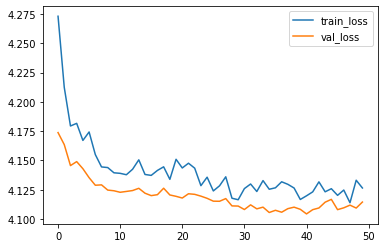

In [53]:
_ = log.plot()

We can get the partial log-likelihood

In [54]:
class Evaluator:
    def __init__(self, df, train_index):
        '''the input duration_train should be the raw durations (continuous),
        NOT the discrete index of duration.
        '''
        self.df_train_all = df.loc[train_index]

    def eval_single(self, model, test_set, config, val_batch_size=None):
        df_train_all = self.df_train_all
        get_target = lambda df: (df['duration'].values, df['event'].values)
        durations_train, events_train = get_target(df_train_all)
        print('durations_train', durations_train)
        et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                        dtype = [('e', bool), ('t', float)])
        print('et_train', et_train)
        times = config['duration_index'][1:-1]
        print('times', times)
        horizons = config['horizons']

        df_test, df_y_test = test_set
        _ = model.compute_baseline_hazards()
        surv = model.predict_surv(df_test)
        risk = np.array((1 - surv))
        print('risk', risk)
        
        durations_test, events_test = get_target(df_y_test)
        print('durations_test', durations_test)
        print('events_test', events_test)
        et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                    dtype = [('e', bool), ('t', float)])
        print('et_test', et_test)
        metric_dict = defaultdict(list)
        cis = []
        for i, _ in enumerate(times):
            print('iteration', i)
            print('risk', risk[:, i])
            print(times)
            cis.append(
                concordance_index_ipcw(et_train, et_test, estimate=risk[:, i], tau=times[i])[0]
                )
            metric_dict[f'{horizons[i]}_ipcw'] = cis[i]


        for horizon in enumerate(horizons):
            print(f"For {horizon[1]} quantile,")
            print("TD Concordance Index - IPCW:", cis[horizon[0]])
        
        return metric_dict

In [55]:
evaluator = Evaluator(df, df_train.index)
evaluator.eval_single(model, (x_test, df_y_test), config=pc_hazard_config)

durations_train [ 30. 892.   7. ...  36.   6. 879.]
et_train [( True,  30.) (False, 892.) ( True,   7.) ... ( True,  36.) ( True,   6.)
 (False, 879.)]
times [ 14.    57.   250.25]
risk [[0.19748926 0.37678933 0.5579516  0.7299253 ]
 [0.13705331 0.27153373 0.42127556 0.58398837]
 [0.19218022 0.3678943  0.5470031  0.71911883]
 ...
 [0.17784595 0.34354067 0.5164533  0.6881303 ]
 [0.21640319 0.40793163 0.59539026 0.7656565 ]
 [0.11740786 0.23542291 0.37086266 0.5243659 ]]
durations_test [  31.  827.   79. ...  640.   51. 1388.]
events_test [1 0 1 ... 0 1 1]
et_test [( True,   31.) (False,  827.) ( True,   79.) ... (False,  640.)
 ( True,   51.) ( True, 1388.)]
iteration 0
risk [0.19748926 0.13705331 0.19218022 ... 0.17784595 0.21640319 0.11740786]
[ 14.    57.   250.25]
iteration 1
risk [0.37678933 0.27153373 0.3678943  ... 0.34354067 0.40793163 0.23542291]
[ 14.    57.   250.25]
iteration 2
risk [0.5579516  0.42127556 0.5470031  ... 0.5164533  0.59539026 0.37086266]
[ 14.    57.   250.25

defaultdict(list,
            {'0.25_ipcw': 0.5842720628390605,
             '0.5_ipcw': 0.5915099336681312,
             '0.75_ipcw': 0.6060352211072264})